In [1]:
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean.cm as cmo
#import functions as fun

In [2]:
#mods = fun.models()
mods = ['bcc-csm1-1','CanESM2','CCSM4','CNRM-CM5','CSIRO-Mk3-6-0','GFDL-CM3','GISS-E2-R','HadGEM2-ES','inmcm4','IPSL-CM5A-LR','MIROC-ESM','MIROC5','MRI-CGCM3','NorESM1-M']

In [3]:
mpl.rcParams['xtick.labelsize']       = 9
mpl.rcParams['ytick.labelsize']       = 9
mpl.rcParams['lines.linewidth']       = 2.
mpl.rcParams['axes.labelsize']        = 9
#mpl.rcParams['axes.labelweight']      = 'bold'
mpl.rcParams['axes.titlesize']        = 9
mpl.rcParams['font.family']           = 'serif'
#mpl.rcParams['axes.titleweight']      = 'bold'
mpl.rcParams['figure.subplot.bottom'] = .01
mpl.rcParams['figure.subplot.top']    = .97
mpl.rcParams['figure.subplot.left']   = .05
mpl.rcParams['figure.subplot.right']  = .8
mpl.rcParams['figure.subplot.wspace'] = .02
mpl.rcParams['figure.subplot.hspace'] = .01
mpl.rcParams['figure.figsize']        = 7,2.5


cols = {}
cols['ocean'] = '.7'
cols['land'] = '.9'

In [4]:
#Get 1x1 degree grid
with xr.open_dataset('../rawdata/rsl_85_2090.nc') as ds:
    lon = ds['x'].values
    lat = ds['y'].values
    slr_md = ds['slr_md'].values

In [5]:
def sig(var):
    return np.std(var,axis=0)

In [6]:
def get_mms(scen):
    with xr.open_dataset(f'../data/rsl/{mods[0]}_{scen}.nc') as ds:
        lon = ds['lon'].values
        lat = ds['lat'].values
    mm = np.zeros((len(mods),len(lat),len(lon)))

    for m,model in enumerate(mods):
        with xr.open_dataset(f'../data/rsl/{model}_{scen}.nc') as ds:
            stdn = np.nanmean(ds['stdn'][-20:,:,:].values,axis=0)
            glac = np.nanmean(ds['glac'][-20:,:,:].values,axis=0)
            gsmb = np.nanmean(ds['gsmb'][-20:,:,:].values,axis=0)
            asmb = np.nanmean(ds['asmb'][-20:,:,:].values,axis=0)
            adyn = np.nanmean(ds['adyn'][-20:,:,:].values,axis=0)
            
            mm[m,:,:] = stdn+glac+gsmb+asmb+adyn

    mms = np.nanvar(mm,axis=0)
    mms[np.isnan(slr_md)]=np.nan
    return mms

In [7]:
def get_refcov(scen):
    stdn = np.zeros((len(mods),len(lat),len(lon)))
    adyn = np.zeros((len(mods),len(lat),len(lon)))
    asmb = np.zeros((len(mods),len(lat),len(lon)))
    gsmb = np.zeros((len(mods),len(lat),len(lon)))
    glac = np.zeros((len(mods),len(lat),len(lon)))
    
    for m,model in enumerate(mods):
        #Read RSL
        with xr.open_dataset(f'../data/rsl/{model}_{scen}.nc') as ds:
            stdn[m,:,:] = np.nanmean(ds['stdn'][-20:,:,:].values,axis=0)
            adyn[m,:,:] = np.nanmean(ds['adyn'][-20:,:,:].values,axis=0)
            asmb[m,:,:] = np.nanmean(ds['asmb'][-20:,:,:].values,axis=0)
            gsmb[m,:,:] = np.nanmean(ds['gsmb'][-20:,:,:].values,axis=0)
            glac[m,:,:] = np.nanmean(ds['glac'][-20:,:,:].values,axis=0)
            
    srocc = ((sig(stdn)+sig(asmb)+sig(gsmb))**2+sig(glac)**2+sig(adyn)**2)
    srocc[np.isnan(slr_md)]=np.nan
    
    nocov = (sig(stdn)**2+sig(glac)**2+sig(gsmb)**2+sig(asmb)**2+sig(adyn)**2)
    nocov[np.isnan(slr_md)]=np.nan

    return srocc,nocov

In [8]:
def makeglobal(ax):
    ax.set_global()
    ax.add_feature(cfeature.LAND,color=cols['land'])
    ax.add_feature(cfeature.OCEAN,color=cols['ocean'])
    ax.outline_patch.set_visible(False)

/Users/erwin/miniconda2/envs/codep/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':
/Users/erwin/miniconda2/envs/codep/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.
/Users/erwin/miniconda2/envs/codep/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()
/Users/erwin/miniconda2/envs/codep/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == '':
/Users/erwin/miniconda2/envs/codep/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice
  del sys.path[0]
/Users/erwin/miniconda2/envs/codep/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Degrees of freedom <= 0 for slice.
/Users/erwin/miniconda2/envs/codep/lib/python3.6/site

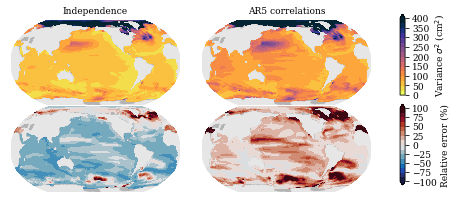

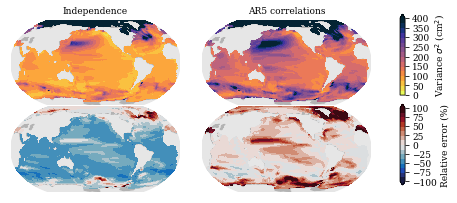

In [9]:
#cmap1 = plt.get_cmap('cmo.speed',16)
cmap1 = plt.get_cmap('cmo.thermal_r',16)
cmap2 = plt.get_cmap('cmo.balance',16)
vmax1 = 400
vmax2 = 100

for s,scen in enumerate(['rcp45','rcp85']):

    fig = plt.figure()
    
    mm = get_mms(scen)
    sr,nc = get_refcov(scen)
    
    ax = fig.add_subplot(2,2,1,projection=ccrs.Robinson(central_longitude=200))
    im = ax.pcolormesh(lon,lat,nc,transform=ccrs.PlateCarree(),vmin=0,vmax=vmax1,cmap=cmap1)
    makeglobal(ax)
    ax.set_title('Independence')
    ax = fig.add_subplot(2,2,3,projection=ccrs.Robinson(central_longitude=200))
    im2 = ax.pcolormesh(lon,lat,100.*(nc-mm)/mm,transform=ccrs.PlateCarree(),vmin=-vmax2,vmax=vmax2,cmap=cmap2)    
    makeglobal(ax)
    
    ax = fig.add_subplot(2,2,2,projection=ccrs.Robinson(central_longitude=200))
    im = ax.pcolormesh(lon,lat,sr,transform=ccrs.PlateCarree(),vmin=0,vmax=vmax1,cmap=cmap1)
    makeglobal(ax)
    ax.set_title('AR5 correlations')
    ax = fig.add_subplot(2,2,4,projection=ccrs.Robinson(central_longitude=200))
    im2 = ax.pcolormesh(lon,lat,100.*(sr-mm)/mm,transform=ccrs.PlateCarree(),vmin=-vmax2,vmax=vmax2,cmap=cmap2)        
    makeglobal(ax)
       
    cax = fig.add_axes([.84,.55,.01,.45])
    cb = plt.colorbar(im,cax=cax,extend='max')
    cb.set_label('Variance $\sigma^2$ (cm$^2$)')

    cax = fig.add_axes([.84,.05,.01,.45])
    cb = plt.colorbar(im2,cax=cax,extend='both')
    cb.set_label('Relative error (%)')

    figname = f'draftplot_regvar_error_{scen}.png'

    plt.savefig(f'../figures/{figname}',dpi=600)
    plt.savefig(f'../../../writing/codependence/figures/{figname}',dpi=600)
    plt.show()
    plt.close()